In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/EVCS/Electric_Vehicle_Charging_Station_Data_-8671638762898357044.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148136 entries, 0 to 148135
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Station_Name                148136 non-null  object 
 1   Address                     148136 non-null  object 
 2   City                        148136 non-null  object 
 3   State_Province              148136 non-null  object 
 4   Zip_Postal_Code             148136 non-null  int64  
 5   Start_Date___Time           148136 non-null  object 
 6   Start_Time_Zone             148136 non-null  object 
 7   End_Date___Time             148132 non-null  object 
 8   End_Time_Zone               148136 non-null  object 
 9   Total_Duration__hh_mm_ss_   148136 non-null  object 
 10  Charging_Time__hh_mm_ss_    148136 non-null  object 
 11  Energy__kWh_                148136 non-null  float64
 12  GHG_Savings__kg_            148136 non-null  float64
 13  Gasoline_Savin

**This function takes a string representing a time duration in the format 'hh:mm:ss' and converts it to total seconds.
Convert Time Durations to Seconds:**

**The duration_to_seconds function is applied to two columns of the dataset:**

'Total_Duration_hh_mm_ss'
'Charging_Time_hh_mm_ss'

The resulting total seconds are stored in new columns 'Total_Duration_Seconds' and 'Charging_Time_Seconds', respectively.

**Feature Selection/Engineering:**

Selects three columns from the dataset:

**'Total_Duration_Seconds', 'Charging_Time_Seconds', and 'Energy_kWh'.**

**Anomaly Detection Model:**

Creates an Isolation Forest model with a contamination parameter set to 0.1, indicating the expected proportion of anomalies in the dataset.

Fits the model to the selected features.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest


# Preprocessing: Convert time durations to total seconds
def duration_to_seconds(duration_str):
    parts = duration_str.split(':')
    hours = int(parts[0])
    minutes = int(parts[1])
    seconds = int(parts[2])
    return hours * 3600 + minutes * 60 + seconds

data['Total_Duration_Seconds'] = data['Total_Duration__hh_mm_ss_'].apply(duration_to_seconds)
data['Charging_Time_Seconds'] = data['Charging_Time__hh_mm_ss_'].apply(duration_to_seconds)

# Feature selection/engineering
features = data[['Total_Duration_Seconds', 'Charging_Time_Seconds', 'Energy__kWh_']]

# Anomaly Detection Model
model = IsolationForest(contamination=0.1)  # Contamination refers to the expected proportion of anomalies in the dataset
model.fit(features)
anomaly_scores = model.decision_function(features)

# Convert anomaly scores to a pandas Series
anomaly_scores_series = pd.Series(anomaly_scores)

# Determine threshold (e.g., using percentiles)
threshold = anomaly_scores_series.quantile(0.1)  # Adjust percentile as needed

# Label anomalies
data['Anomaly_Label'] = anomaly_scores_series.apply(lambda x: 1 if x < threshold else 0)

# Save or use the labeled dataset for further analysis
data.to_csv("labeled_dataset.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


data,head

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/EVCS/labeled_dataset.csv")

In [ ]:
X = data.drop(['Anomaly_Label'], axis=1)
y = data['Anomaly_Label']

In [ ]:
X.head()

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectID,ObjectId2,Total_Duration_Seconds,Charging_Time_Seconds
0,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/1/2018 17:49,MDT,1/1/2018 19:52,MDT,2:03:02,2:02:44,6.504,2.732,0.816,Level 2,0,1,7382,7364
1,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 8:52,MDT,1/2/2018 9:16,MDT,0:24:34,0:24:19,2.481,1.042,0.311,Level 2,1,2,1474,1459
2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 21:11,MDT,1/3/2018 6:23,MDT,9:12:21,3:40:52,15.046,6.319,1.888,Level 2,2,3,33141,13252
3,BOULDER / ALPINE ST1,1275 Alpine Ave,Boulder,Colorado,80304,1/3/2018 9:19,MDT,1/3/2018 11:14,MDT,1:54:51,1:54:29,6.947,2.918,0.872,Level 2,3,4,6891,6869
4,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,1/3/2018 14:13,MDT,1/3/2018 14:30,MDT,0:16:58,0:16:44,1.800,0.756,0.226,Level 2,4,5,1018,1004


In [ ]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Anomaly_Label, dtype: int64

In [ ]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({0: 133322, 1: 14814})


**Separate Numerical and Categorical Columns:**

**X_numeric and X_categorical store the numerical and categorical parts of the dataset X, respectively.**

**Impute Missing Values in Numerical Columns:**

Uses SimpleImputer with the strategy set to 'mean' to fill missing values in numerical columns (X_numeric).

**Impute Missing Values in Categorical Columns:**

Utilizes SimpleImputer with the strategy set to 'most_frequent' to fill missing values in categorical columns (X_categorical).

**Combine Imputed Numerical and Categorical Data:**

Merges the imputed numerical and categorical data into a single DataFrame (X_imputed).

**Initialize SMOTE-NC:**

Initializes SMOTENC with the categorical features' indices in the combined dataset (X_imputed) for synthetic minority oversampling.

In [ ]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC
import pandas as pd



# Identify categorical and continuous features
categorical_features = ['Station_Name', 'City', 'State_Province']
continuous_features = ['Total_Duration_Seconds', 'Charging_Time_Seconds', 'Energy__kWh_']

# Separate numerical and categorical columns
X_numeric = X[continuous_features]
X_categorical = X[categorical_features]

# Impute missing values in numerical columns
imputer_numeric = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer_numeric.fit_transform(X_numeric)

# Impute missing values in categorical columns
imputer_categorical = SimpleImputer(strategy='most_frequent')
X_categorical_imputed = imputer_categorical.fit_transform(X_categorical)

# Combine imputed numerical and categorical data
X_imputed = pd.concat([pd.DataFrame(X_numeric_imputed, columns=continuous_features),
                       pd.DataFrame(X_categorical_imputed, columns=categorical_features)], axis=1)

# Initialize SMOTE-NC
smote_nc = SMOTENC(categorical_features=[X_imputed.columns.get_loc(col) for col in categorical_features], random_state=42)

# Perform balancing
X_resampled, y_resampled = smote_nc.fit_resample(X_imputed, y)



In [ ]:
from collections import Counter
counter = Counter(y_resampled)
print(counter)

Counter({0: 133322, 1: 133322})


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.layers import Input, Dense, Multiply, Add, Lambda, concatenate
from keras.models import Model
from tensorflow.keras.utils import to_categorical
import time


# Load the balanced dataset
balanced_data = pd.read_csv("/content/drive/MyDrive/EVCS/balanced_dataset.csv")

# Separate features and target variable
X = balanced_data.drop(columns=['Anomaly_Label'])
y = balanced_data['Anomaly_Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train[['Station_Name', 'City', 'State_Province']]).toarray()
X_test_encoded = encoder.transform(X_test[['Station_Name', 'City', 'State_Province']]).toarray()

# Concatenate encoded features with numerical features
X_train_processed = np.concatenate([X_train_encoded, X_train.drop(columns=['Station_Name', 'City', 'State_Province']).values], axis=1)
X_test_processed = np.concatenate([X_test_encoded, X_test.drop(columns=['Station_Name', 'City', 'State_Province']).values], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import time

cl = PassiveAggressiveClassifier(random_state = 30)
start_time = time.time()
cl.fit(X_train_processed, y_train)
end_time = time.time()

# Predict on the testing set
y_pred = cl.predict(X_test_processed)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='weighted')

execution_time = end_time - start_time

# calculate prediction

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print(f"Execution Time: {execution_time}")

Accuracy: 0.7408351928594198
F1 Score: 0.7237862872715801
Precision: 0.981
Recall: 0.741
Execution Time: 8.350805282592773


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import time


# Train the classifier
clf = RidgeClassifier()
start_time = time.time()
clf.fit(X_train_processed, y_train)
end_time = time.time()

# Predict on the testing set
y_pred = clf.predict(X_test_processed)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
execution_time = end_time - start_time

# calculate prediction

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print(f"Execution Time: {execution_time}")

Accuracy: 0.8920099758105346
F1 Score: 0.8918428511872443
Precision: 0.927
Recall: 0.852
Execution Time: 0.393890380859375


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import time

# Fitting SGD Classifier to the Training set
model = SGDClassifier(random_state= 42)
start_time = time.time()
model.fit(X_train_processed, y_train)
nd_time = time.time()

# Predicting the results
y_pred = model.predict(X_test_processed)

#Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
execution_time = nd_time - start_time

# calculate prediction

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print(f"Execution Time: {execution_time}")

Accuracy: 0.808434435297868
F1 Score: 0.8010924257805542
Precision: 0.861
Recall: 0.808
Execution Time: 5.422912836074829


In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

# get a stacking ensemble of models
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('rc', RidgeClassifier()))
 level0.append(('pac', PassiveAggressiveClassifier(random_state=30)))

 # define meta learner model
 level1 = SGDClassifier(random_state = 42)
 # define the stacking ensemble
 model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
 return model

# get a list of models to evaluate
def get_models():
 models={}
 models = dict()

 models['stacking'] = get_stacking()
 return models




In [ ]:
import time
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate f1 score and execution time for a given model and data
def evaluate_model(model, X_train_processed, X_test_processed, y_train, y_test):
    start_time = time.time()
    model.fit(X_train_processed, y_train)
    exec_time = time.time() - start_time
    y_pred = model.predict(X_test_processed)
    score = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    return score, f1, exec_time, precision, recall

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names, f1_scores, exec_times, precision_scores, recall_scores = list(), list(), list(), list(), list(), list()
for name, model in models.items():
    score, f1, exec_time, precision, recall = evaluate_model(model, X_train_processed, X_test_processed, y_train, y_test)
    results.append(score)
    names.append(name)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    exec_times.append(exec_time)
    print('>%s: accuracy=%.3f, f1=%.3f, exec_time=%.3f, precision=%.3f, recall=%.3f' % (name, score, f1, exec_time, precision, recall))


>stacking: accuracy=0.926, f1=0.924, exec_time=28.640, precision=0.959, recall=0.891


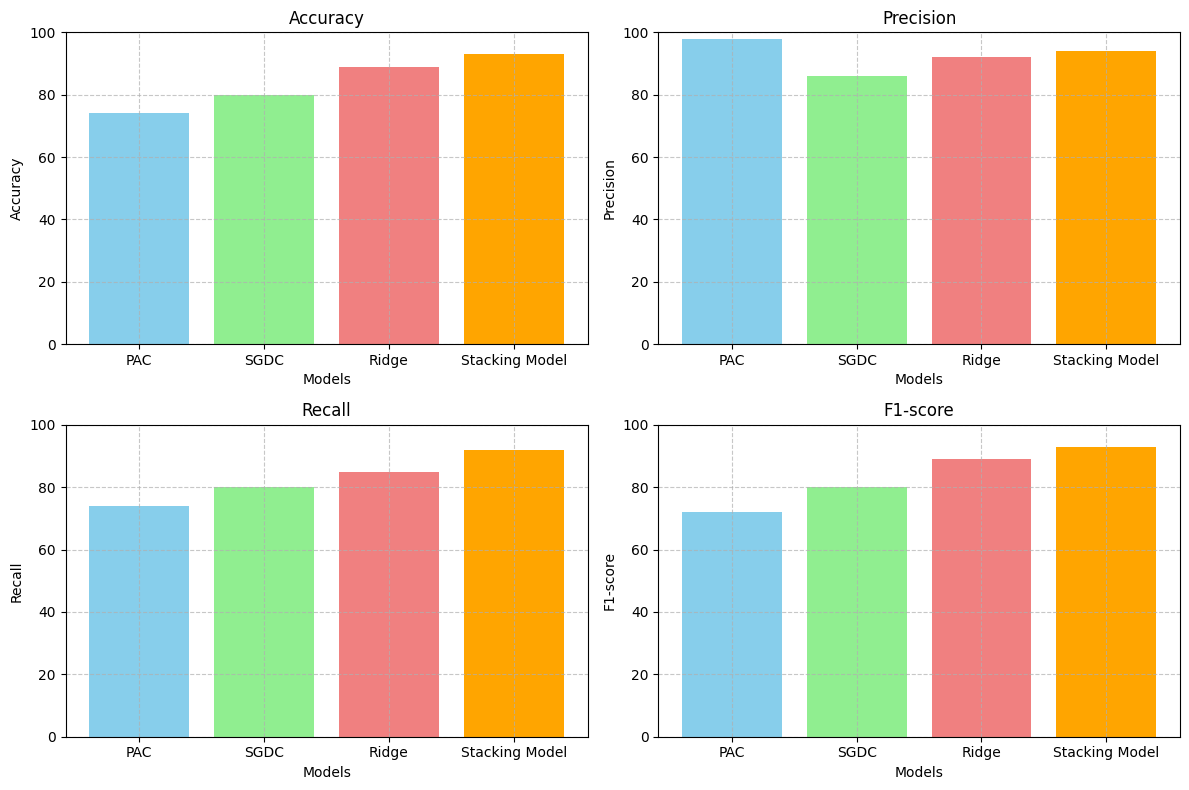

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['PAC', 'SGDC', 'Ridge', 'Stacking Model']
accuracy = [74, 80, 89, 93]
precision = [98, 86, 92, 94]
recall = [74, 80, 85, 92]
f1_score = [72, 80, 89, 93]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
data = [accuracy, precision, recall, f1_score]

for i in range(4):
    axes[i].bar(models, data[i], color=['skyblue', 'lightgreen', 'lightcoral', 'orange'])
    axes[i].set_title(metrics[i])
    axes[i].set_ylabel(metrics[i])
    axes[i].set_xlabel('Models')
    axes[i].set_ylim([0, 100])
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/evcs_all_models.pdf", format="pdf", bbox_inches="tight")
plt.show()
